In [1]:
# import functions
import sys,os
import glob
try: 
    if(cwd is not None):
        from functions.utils_binary import *
except:
    %cd ..
    cwd = os.getcwd()
    sys.path.insert(0,cwd)
    from functions.utils_binary import *

d:\cheminformatics_pipeline


In [ ]:
# prepare data for training
defineXY(testSize=0.2, trainSize=0.8, randomState=4)

## XGBoost, Ada and LightGBM pipeline

In [ ]:
# setting search space

xgb_search = {
'learning_rate': Real(0.01, 1.0, 'uniform'),
'max_depth': Integer(2, 12),
'subsample': Real(0.1, 1.0, 'uniform'),
'colsample_bytree': Real(0.1, 1.0, 'uniform'),
'reg_alpha': Real(1e-9, 100., 'uniform'),
'n_estimators': Integer(50, 5000)
}

ada_search = {
    'learning_rate': Real(0.005, 0.9, prior="log-uniform"),
    'n_estimators': Integer(1, 1000),
}

lgbm_search = {
    'reg_sqrt': Categorical([True, False]),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(1, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

In [ ]:
# scorer
f1_scorer = make_scorer(f1_score, pos_label=1)

# Setting the validation strategy
inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [ ]:
# initiate models
init_models = [xgb.XGBClassifier(), LGBMClassifier(), AdaBoostClassifier()]

# search spaces
search_spaces = [xgb_search, lgbm_search, ada_search]

In [ ]:
# define fp generated
fp_generated = ['ecfp_fp_2_1024', 'fcfp_fp_2_1024', 'maccs_fp']

for fp in fp_generated:

    # run through x train
    for file in os.listdir('./data/curated_data/x/binary/x_train/'):

        # run through y train
        for file_ in os.listdir('./data/curated_data/y/binary/y_train/'):

            # check if file is json file
            if file.endswith('json'):

                #check if files share the same fp, if so, continue
                if file.find(fp) != -1 and  file_.find(fp) != -1:
                    
                    # load x_train
                    with open(f'./data/curated_data/x/binary/x_train/{file}', 'r') as x_train:
                        x_train = json.load(x_train)
                        x_train= np.asarray(x_train)


                    # load y_train
                    with open(f'./data/curated_data/y/binary/y_train/{file_}', 'r') as y_train:
                        y_train = json.load(y_train)
                        y_train= np.asarray(y_train)

                    # training
                    bayessearch(
                        models = init_models, 
                        search_spaces = search_spaces, 
                        scorer = f1_scorer,
                        inner_cv = inner_skf,
                        outer_cv = outer_skf,
                        x = x_train,
                        y = y_train,
                        fp = fp
                    )

In [ ]:
# generate external set confusion matrix
validatemodels()

In [ ]:
from sklearn import metrics
with open(f'./data/curated_data/x/binary/x_train/x_train_ecfp_fp_2_1024.json', 'r') as x_train:
    x_train = json.load(x_train)
    x_train= np.asarray(x_train)


# load y_train
with open(f'./data/curated_data/y/binary/y_train/y_train_ecfp_fp_2_1024.json', 'r') as y_train:
    y_train = json.load(y_train)
    y_train= np.asarray(y_train)



model = load('./data/models/binary/ada_classifier_ecfp_fp_2_1024.joblib')
scores = cross_validate(model, x_train, y_train, cv=outer_skf, scoring='roc_auc', return_train_score=True)

In [ ]:
def validatemodels ():

    # load model
    for clf in os.listdir('./data/models/binary/'):
        if clf.endswith('joblib'):

            # extract fingerprint name used
            s = clf
            result = re.search('classifier_(.*).joblib', s)
            fp_used = result.group(1)

            #extract 5cv metrics name
            result = re.search(f'(.*){fp_used}.joblib', s)
            modelname = result.group(1)

            ############# INTERNAL VALIDATION ############
            



















            ########## EXTERNAL VALIDATION #############
            # load model
            model = load(f'./data/models/binary/{clf}')


            with open(f'./data/curated_data/y/binary/y_ext/y_ext_{fp_used}.json', 'r') as y_ext:
                y_ext = json.load(y_ext)
                y_ext = np.asarray(y_ext)

            # load x_ext
            with open(f'./data/curated_data/x/binary/x_ext/x_ext_{fp_used}.json', 'r') as x_ext:
                x_ext = json.load(x_ext)
                x_ext = np.asarray(x_ext)

            # calculate external metrics
            metrics, cm = metrics_binary(model, x_ext, y_ext)

            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
            disp.plot()

            # save fig
            plt.savefig(f'./data/figs/confusion_matrix_{modelname}{fp_used}.png', dpi=300)


            A = [cm[1, 1], cm[0, 0]]
            B = [cm[1, 0], cm[0, 1]]

            fig = plt.figure(facecolor="white")

            ax = fig.subplots()
            bar_width = 0.9
            bar_l = np.arange(1, 3)
            tick_pos = [i + (bar_width / 30) for i in bar_l]

            ax2 = ax.bar(bar_l, A, width=bar_width, label="A", color="darkseagreen")
            ax1 = ax.bar(bar_l, B, bottom=A, width=bar_width, label="B", color="lightcoral")
            ax.set_ylabel("Count", fontsize=10)
            totals = [sum([cm[1, 1], cm[1, 0]]), sum([cm[0, 0], cm[0, 1]])]
            plt.legend(["Predicted correctly", "Predicted wrongly"], bbox_to_anchor=(0.45, -0.09), loc='upper center', ncol=1)
            plt.xticks(tick_pos, [f"Total Negatives: {totals[0]}", f"Total Positives: {totals[1]}"], fontsize=10)
            plt.title(f'Confusion Matrix {modelname}{fp_used}')
            plt.yticks(fontsize=10)

            for r1, r2 in zip(ax2, ax1):
                h1 = r1.get_height()
                h2 = r2.get_height()
                plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=10, fontweight="bold")
                plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=10, fontweight="bold")

            plt.savefig(f'./data/figs/barplotconfusion_matrix_{modelname}{fp_used}.png', dpi=300, bbox_inches = 'tight')

In [6]:
# generate graph with 5-fold-cross validation metrics
fp_used = 'fcfp_fp_2_1024'
# import data
for file_ada in os.listdir('./data/models/binary/metrics/AUC/ada/'):
    for file_lgbm in os.listdir('./data/models/binary/metrics/AUC/lgbm/'):
        for file_xgb in os.listdir('./data/models/binary/metrics/AUC/xgb/'):
            if file.endswith('csv'):
                if file_ada.find('auc') != -1 and file_lgbm.find('auc') != -1 and file_xgb.find('auc') != -1:
                    if file_ada.find(fp_used) != -1 and file_lgbm.find(fp_used) != -1 and file_xgb.find(fp_used) != -1:
                        print(file_ada, file_lgbm, file_xgb)

ada_classifier_auc_fcfp_fp_2_1024.csv lgbm_classifier_auc_fcfp_fp_2_1024.csv xgb_classifier_auc_fcfp_fp_2_1024.csv


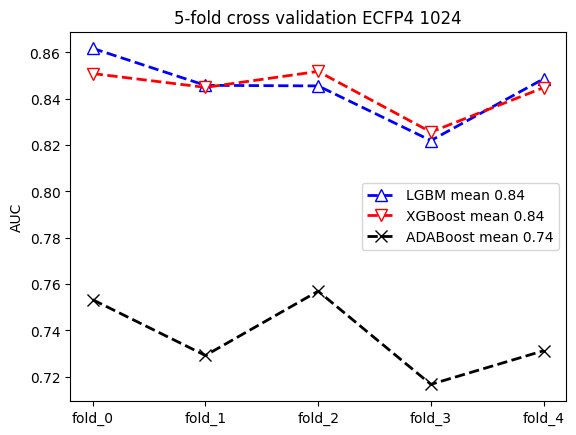

In [45]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as st


ada_df = pd.read_csv('./data/models/binary/metrics/AUC/ada/ada_classifier_auc_maccs_fp.csv')
lgbm_df = pd.read_csv('./data/models/binary/metrics/AUC/lgbm/lgbm_classifier_auc_maccs_fp.csv')
xgb_df = pd.read_csv('./data/models/binary/metrics/AUC/xgb/xgb_classifier_auc_maccs_fp.csv')


dictHolder = pd.DataFrame({'x_values':[], 'LGBM': [], 'ADABoost': [], 'XGBoost':[]})

dictHolder['LGBM'] = [i for i in lgbm_df['test_score']]
dictHolder['ADABoost'] = [i for i in ada_df['test_score']]
dictHolder['XGBoost'] = [i for i in xgb_df['test_score']]
dictHolder['x_values'] = [f'fold_{i}' for i in range(5)]


# multiple line plots
plt.plot( 'x_values', 'LGBM', data=dictHolder, marker='^', markerfacecolor='white', markersize=8, color='blue', linewidth=2, linestyle='dashed', label = f"LGBM mean {round(st.mean(dictHolder['LGBM']), 2)}")
plt.plot( 'x_values', 'XGBoost', data=dictHolder, marker='v', markerfacecolor='white', markersize=8, color='red', linewidth=2, linestyle='dashed', label = f"XGBoost mean {round(st.mean(dictHolder['XGBoost']), 2)}")
plt.plot( 'x_values', 'ADABoost', data=dictHolder, marker='x', markerfacecolor='white', markersize=8, color='black', linewidth=2, linestyle='dashed', label = f"ADABoost mean {round(st.mean(dictHolder['ADABoost']), 2)}")

plt.title('5-fold cross validation ECFP4 1024')
plt.ylabel('AUC')

# show legend
plt.legend()

# show graph
plt.show()



In [ ]:
from PIL import Image


def combine_images(columns, space, images):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    return background.save('image.png')

In [ ]:
combine_images(columns=2, space=30, images=['./data/figs/barplotconfusion_matrix_ada_classifier_ecfp_fp_2_1024.png',
'./data/figs/barplotconfusion_matrix_xgb_classifier_ecfp_fp_2_1024.png'])